<a href="https://colab.research.google.com/github/variableVG/CV_project/blob/master/06_PyTorch_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network 

In this book we finally use Convolutional Neural Networks to predict the age of people in photographs. To achieve this, we used a convolutional neural network that contains the following blocks: 
* Conv2d: It reduces the images into a form which is easier to process, without losing critical features for a good prediction. 
* ReLU. It transforms all negative values to 0. 
* MaxPool2d. Max Pooling returns the maximum value from the portion of the image covered by the Kernel. 
* Flatten. It reshapes the input matrix into a one-dimensional tensor that can be used by the linear layers. 
* Linear. It applies linear transformation to the data. 

Sources:

* https://en.wikipedia.org/wiki/Convolutional_neural_network
* https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data and images


In [2]:
path_to_pictures = '/content/pic/'
path_to_dataset = '/content/drive/MyDrive/Colab Notebooks/CVNLP/dataset_faces_small.csv'

In [3]:
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import torch
import os

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging 
logging.getLogger("matplotlib").setLevel(logging.ERROR)

In order to speed-up computation time we use CUDA (Compute Unified Device Architecture). CUDA is a parallel computing platform and application programming interface (API) that allows software to use certain types of graphics processing units (GPUs) for general purpose processing. Google Collaboratory permits to use GPUs for free up to a certain limit depending on demand. The code below enables us to use GPUs if they are available. The function to_device() will be called when we need to partition the data to optimize the computation.

Source: 
* https://en.wikipedia.org/wiki/CUDA
* https://pytorch.org/docs/stable/notes/cuda.html

In [5]:
# Use Google Collabs GPU
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()

def to_device(data, device=device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [6]:
#Get .tar file with pytorch files from google drive
! pip install gdown
! mkdir -p /content/pic/
! gdown -O /content/pytorch_files.tar "1Eqds2UxvtLkFefRp00wNVdyX4jdiYlav"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1Eqds2UxvtLkFefRp00wNVdyX4jdiYlav
To: /content/pytorch_files.tar
100% 496M/496M [00:06<00:00, 77.5MB/s]


In [7]:
import tarfile
try: 
  tar = tarfile.open('/content/pytorch_files.tar')
  tar.extractall(path='/content/pic')
  tar.close()
except:
  print("Pictures could not be extracted")

In [8]:
! mv /content/pic/content/drive/MyDrive/Colab\ Notebooks/CVNLP/normalized_tensor_images/* /content/pic/
! rmdir /content/pic/content

rmdir: failed to remove '/content/pic/content': Directory not empty


In [9]:
df = pd.read_csv(path_to_dataset)

In [10]:
df.head()

,filename,age,gender,ethnicity
0,36_1_1_20170116223054510.jpg,36,1,1
1,36_1_1_20170117165628076.jpg,36,1,1
2,37_0_0_20170117140720825.jpg,37,0,0
3,37_0_1_20170116193744974.jpg,37,0,1
4,37_0_1_20170117140332549.jpg,37,0,1


In [11]:
df.shape

(2501, 4)

# Save some data separately to test the algorithm 

We are going to separate 16 pictures to make some predictions at the end of this notebook. These 16 photos will not be used by the model to train or test (validate). This means that our model has never seen these photographs until the moment of prediction. We will see then, how well (or bad) our network works.

We are aware that 16 photos are probably not enough to test an algorithm, but we wanted to use most of the photos available for training. Moreover, 16 photos can be easily interpreted by a human with a single glance.


In [12]:
import random
# Generate a list of 16 random indexes
random_indexes = [random.randint(0,len(df)) for i in range(0,16)]

# Create a new DataFrame that stores the information for those 16 pictures. 
pictures_for_prediction = pd.DataFrame()

for idx in random_indexes: 
  # Add picture to new dataset
  pictures_for_prediction = pictures_for_prediction.append(df.iloc[idx], ignore_index = True)
  # Delete picture from df
  df.drop(idx, inplace=True)

In [13]:
print(df.shape)
print(pictures_for_prediction.shape)

(2485, 4)
(16, 4)


# Create Dataset, load pictures and apply Data Augmentation

Since the RAM was constantly crashing, we used this class that uploads the snapshots and performs data augmentation on them as needed.

Source: 
* https://pytorch.org/docs/stable/data.html
* https://pytorch.org/vision/stable/transforms.html

In [14]:
class TensorDataset(torch.utils.data.Dataset):  # TensorDataset inherits from torch.utils.data.Dataset
  def __init__(self, df): # Constructor takes a dataframe
    super().__init__()
    self.df = df

    # Initialize an Compose object with different random augmentation objects.
    self.augmentation = T.Compose(
        (T.RandomHorizontalFlip(0.5),
         T.RandomPerspective(0.15, 0.25),
         T.RandomAdjustSharpness(0, 0.25),
         T.RandomRotation(15),
         )
    )

  def __len__(self): 
    return len(self.df)

  def doAugmentation(self, torch_picture): 
    picture = self.augmentation(torch_picture)
    return picture

  def __getitem__(self, idx): # by __getitem__ return a tupel of (picture, label)
    basename, extension = os.path.splitext(self.df['filename'].iloc[idx]) # get name of pythorch file
    path = path_to_pictures + basename + '.pth'
    label = self.df['age'].iloc[idx] # get label
    torch_picture = torch.load(path)
    # DATA AUGMENTATION
    torch_picture = self.doAugmentation(torch_picture)
    return (torch_picture, label)

In [15]:
# Create tensor dataset 
tensor_dataset = TensorDataset(df)
print(len(tensor_dataset))

2485


In [43]:
img, label = tensor_dataset[8] # get item 3
print(img.shape, label)
# Element at index 3 is a pytorch image with age 37. 

torch.Size([3, 128, 128]) 37


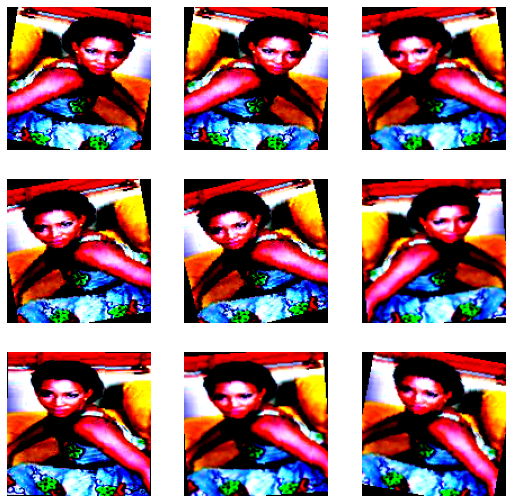

In [42]:
# Check how data augmentation looks like for picture 3 in dataset
plt.figure(figsize=(9,9))

for i in range(9):
  plt.subplot(3, 3, i + 1) # index starts from 1, not 0 
  plt.imshow(tensor_dataset[8][0].permute(1, 2, 0))      
  plt.axis('off')

# Split Data

In [18]:
# Set data size
test_size = int(len(tensor_dataset) * 0.2)
train_size = len(tensor_dataset) - test_size
print(f"Dataset has length {len(tensor_dataset)}, train set has length {train_size} and validation set has length {test_size}.")
print(f"Sum of test and train sets is {train_size + test_size}.")

Dataset has length 2485, train set has length 1988 and validation set has length 497.
Sum of test and train sets is 2485.


In [19]:
from torch.utils.data import random_split
random_seed = 42
torch.manual_seed(random_seed)

# Split dataset
train_ds, test_ds = random_split(tensor_dataset, [train_size, test_size])
print(len(train_ds))
print(len(test_ds))

1988
497


# Load data with DataLoader and set batch size

https://pytorch.org/docs/stable/data.html

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [20]:
# Load Data with DataLoader
batch_size=8

from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_ds, batch_size)

# Create Model

To create the CNN model I used the example in https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

In [21]:
# Define initial number of kernels. 
num_pixels_x = 128
num_pixels_y = 128
num_kernels = 16

In [74]:
from torch import nn

class Model(nn.Module): 
  def __init__(self): 
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, num_kernels, kernel_size=3, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 
        #MaxPool reduce the size of the image by half (if it was 32x32, becomes 16x16)

        nn.Conv2d(num_kernels*2, num_kernels*3, kernel_size=3, padding=1, stride=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*3, num_kernels*3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), 

        nn.Conv2d(num_kernels*3, num_kernels*4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(), 
        nn.Conv2d(num_kernels*4, num_kernels*4, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        # MaxPool2d reduces the image of a picture by half
        nn.MaxPool2d(2,2), # Output:8x4096

        # Flatten() reduces the 3 dimensions in one dimension. 
        nn.Flatten(), 
        nn.Linear(num_pixels_x*num_pixels_y*num_kernels // 16, num_kernels*4), 
        nn.ReLU(),
        nn.Linear(num_kernels*4, num_kernels*2),
        nn.ReLU(),
        nn.Linear(num_kernels*2, 1), 
        #nn.ReLU(), # To make sure there is at the end a number > 0
    )
  def forward(self, x):
    return self.network(x)

# Train the model

In [75]:
def fit(model, train_loader, num_epochs, optimizer, loss_function):
  total_losses = []
  for epoch in range(num_epochs): # for each number of epochs. 
    model.train()
    sumloss = []
    for x, y in train_loader: # for each batch in the train loader: 
      x, y = to_device([x, y])
      prediction = model(x) # The prediction is 3x1 but we need a tensor of 3.
      prediction = prediction.squeeze()
      loss = loss_function(prediction, y)
      sumloss.append(loss.detach().item())
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    print(f"Epoch [{epoch + 1 }/{num_epochs}] loss: {np.mean(sumloss):.3f}.")
    total_losses.append(np.mean(sumloss))
  return total_losses


In [76]:
def evaluate(loader):
  # Get predictions
  absolute_error, total = 0, 0 

  # This tells PyTorch that the model is in evalution mode. This is to avoid that the model keeps saving weights and so on, also for performance reasons. 
  model.eval() 
  for idx, (x, y) in enumerate(loader):
    x, y = to_device((x,y))
    prediction = model(x).squeeze()
    #max_prob, prediction = torch.max(output, 1)
    total += y.size(0)
    absolute_error += ((prediction - y).abs()).sum().item()

  mean_absolute_error = absolute_error/ total 
  return mean_absolute_error

In [77]:
# Initialize the model
model = to_device(Model())

In [78]:
# Get how many parameters are in the model 
number_param = 0
for param in model.parameters():
  number_param = number_param + np.prod(param.shape)

print(number_param)

1155137


We define the loss function as the mean absolute error. 

https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

In [79]:
# define loss function
loss_function = nn.L1Loss()

For the optimizer we used Adam, since it seems to automatically calibrate the learning rates and it offers a good optimization. Due to time restrictions, we could not investigate all the optimizers, but PyTorch describes some of them here:

https://pytorch.org/docs/stable/optim.html

In [80]:
# Create Optimizer
optimizer = torch.optim.Adam(model.parameters())
# Other optimizer could be the stochastic gradient descent
# torch.optim.SGD(model.parameters(), lr=1e-5)

# Define num of epochs: 
num_epochs = 50

# Train the model using the function above: 
loss = fit(model, train_loader, num_epochs, optimizer, loss_function)

Epoch [1/50] loss: 18.852.
Epoch [2/50] loss: 17.574.
Epoch [3/50] loss: 16.902.
Epoch [4/50] loss: 16.761.
Epoch [5/50] loss: 16.776.
Epoch [6/50] loss: 16.737.
Epoch [7/50] loss: 16.535.
Epoch [8/50] loss: 16.556.
Epoch [9/50] loss: 16.330.
Epoch [10/50] loss: 16.390.
Epoch [11/50] loss: 16.121.
Epoch [12/50] loss: 16.874.
Epoch [13/50] loss: 16.812.
Epoch [14/50] loss: 16.881.
Epoch [15/50] loss: 16.903.
Epoch [16/50] loss: 16.690.
Epoch [17/50] loss: 16.186.
Epoch [18/50] loss: 16.150.
Epoch [19/50] loss: 15.893.
Epoch [20/50] loss: 16.164.
Epoch [21/50] loss: 15.867.
Epoch [22/50] loss: 16.011.
Epoch [23/50] loss: 15.789.
Epoch [24/50] loss: 15.758.
Epoch [25/50] loss: 16.193.
Epoch [26/50] loss: 15.959.
Epoch [27/50] loss: 15.696.
Epoch [28/50] loss: 15.584.
Epoch [29/50] loss: 15.335.
Epoch [30/50] loss: 15.163.
Epoch [31/50] loss: 15.249.
Epoch [32/50] loss: 15.075.
Epoch [33/50] loss: 15.077.
Epoch [34/50] loss: 14.921.
Epoch [35/50] loss: 14.926.
Epoch [36/50] loss: 14.817.
E

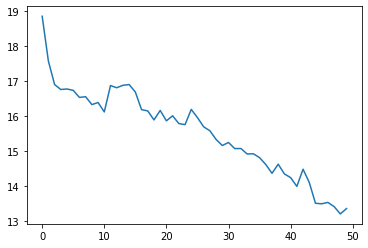

In [81]:
# Plot epocs vs losses
plt.plot(list(range(50)), loss)

In [82]:
# Evaluate model
mean_absolute_error = evaluate(train_loader)
print(f"Traning => Mean Absolute error is {mean_absolute_error:.2f} years")
mean_absolute_error = evaluate(test_loader)
print(f"Testing => Mean Absolute error is {mean_absolute_error:.2f} years")

Traning => Mean Absolute error is 12.58 years
Testing => Mean Absolute error is 15.39 years


# Predict pictures

Remember the 16 pictures we set appart at the beginning? Let's see how well can our algorithm predict the age in those pictures!

In [83]:
def predict(picture_filename_list, model):
  predictions = []
  # Get pictures
  for picture in picture_filename_list:
    basename, extension = os.path.splitext(picture)
    path = path_to_pictures + basename + '.pth'
    pic = torch.load(path)
    # We need to add a batch-dimension of 1 to be able to use the model, since our model works only in batches. 
    # For that we used the unsqueeze() function
    # https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
    pic = to_device(torch.load(path).unsqueeze(0))
    prediction = model(pic)
    # get the item from tensor 
    predictions.append(prediction.item())
  return predictions


In [84]:
# Get the picture we have reserved at the beginning of the blog
predictions = predict(pictures_for_prediction['filename'], model)

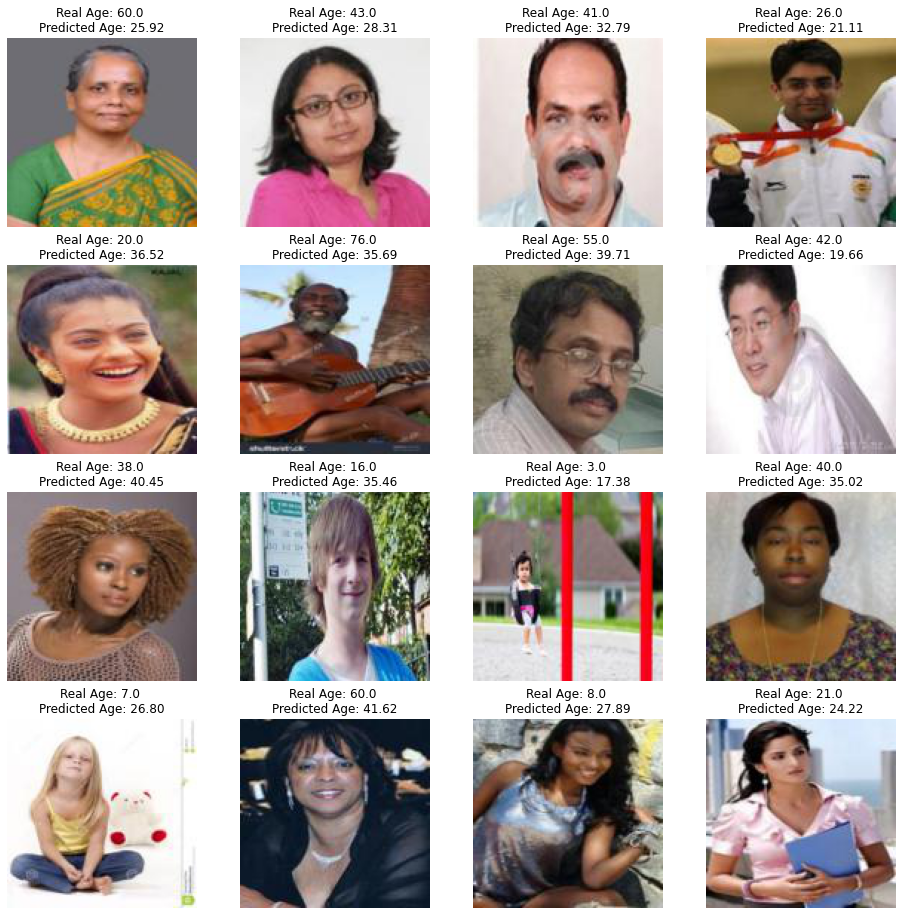

In [85]:
# plot real data and predictions + picture
from PIL import Image
path_to_real_pictures = '/content/drive/MyDrive/Colab Notebooks/CVNLP/small_pic/'
plt.figure(figsize=(16,16))

for i, picture in enumerate(pictures_for_prediction['filename']):
    plt.subplot(4, 4, i + 1) # index starts from 1, not 0
    # get picture
    path = path_to_real_pictures + picture
    try: 
      img = Image.open(path)
      plt.imshow(img)      
    except: 
      print(f"picture in {path} not found")
    plt.title(f"Real Age: {pictures_for_prediction['age'][i]} \nPredicted Age: {predictions[i]:.2f}")
    plt.axis('off')